In [1]:
data = [1, 2, 3, 4, 5]

print(data[:-1])

[1, 2, 3, 4]


In [82]:
import xarray_beam as xbeam
import xarray

ds, _ = xbeam.open_zarr('gcs://era5_climate/512x256/2013-01-01_2023-01-01.zarr')
print(ds.nbytes / (10**9))

125.861871664


In [83]:
import pandas as pd
import numpy as np

start_date = pd.to_datetime('2021-01-01')
end_date = pd.to_datetime('2021-01-03')

source_dataset = ds.sel(time=slice(start_date, end_date))

print(source_dataset)

<xarray.Dataset>
Dimensions:                                         (time: 49, latitude: 36,
                                                     longitude: 36, level: 37)
Coordinates:
  * latitude                                        (latitude) float64 20.04 ...
  * level                                           (level) int64 1 2 ... 1000
  * longitude                                       (longitude) float64 115.3...
  * time                                            (time) datetime64[ns] 202...
Data variables: (12/27)
    10m_u_component_of_wind                         (time, latitude, longitude) float32 ...
    10m_v_component_of_wind                         (time, latitude, longitude) float32 ...
    2m_dewpoint_temperature                         (time, latitude, longitude) float32 ...
    2m_temperature                                  (time, latitude, longitude) float32 ...
    geopotential                                    (time, level, latitude, longitude) float32 ...
 

In [84]:
print(list(source_dataset.keys()))

['10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature', '2m_temperature', 'geopotential', 'geopotential_at_surface', 'land_sea_mask', 'mean_sea_level_pressure', 'mean_surface_latent_heat_flux', 'mean_surface_net_long_wave_radiation_flux', 'mean_surface_net_short_wave_radiation_flux', 'mean_surface_sensible_heat_flux', 'mean_top_downward_short_wave_radiation_flux', 'mean_top_net_long_wave_radiation_flux', 'mean_top_net_short_wave_radiation_flux', 'mean_vertically_integrated_moisture_divergence', 'potential_vorticity', 'specific_humidity', 'surface_pressure', 'temperature', 'total_cloud_cover', 'total_column_water', 'total_column_water_vapour', 'total_precipitation', 'u_component_of_wind', 'v_component_of_wind', 'vertical_velocity']


In [87]:
dataset = source_dataset['land_sea_mask']

print(dataset)

<xarray.DataArray 'land_sea_mask' (latitude: 36, longitude: 36)>
[1296 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 20.04 20.74 21.45 22.15 ... 43.24 43.95 44.65
  * longitude  (longitude) float64 115.3 116.0 116.7 117.4 ... 138.5 139.2 139.9
Attributes:
    long_name:      Land-sea mask
    short_name:     lsm
    standard_name:  land_binary_mask
    units:          (0 - 1)


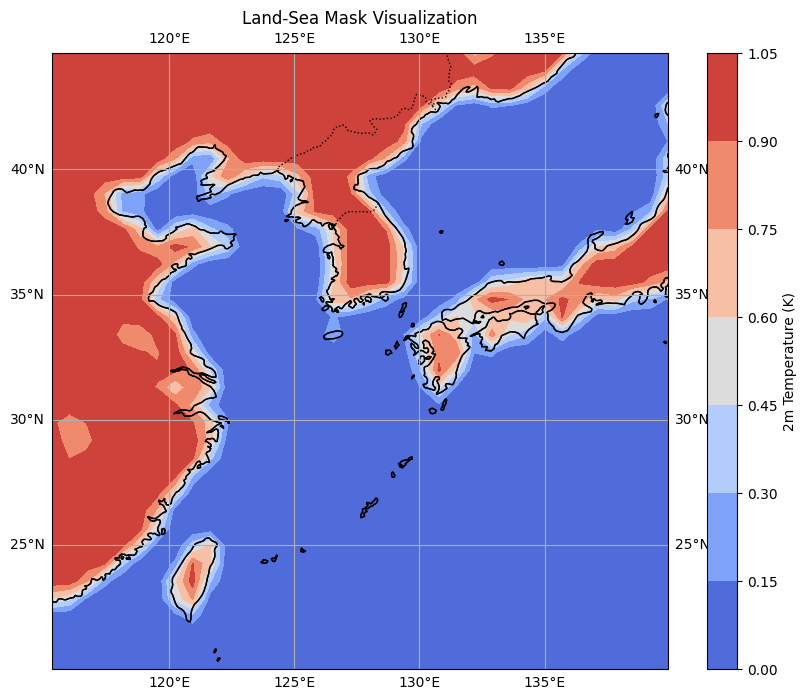

: 

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# 땅과 바다 구분을 위해, 0.5를 기준으로 땅(1)과 바다(0)를 구분
# cmap을 'binary'로 설정하여 땅과 바다를 명확하게 구분
plt.contourf(dataset.longitude.values, dataset.latitude.values, dataset.values, transform=ccrs.PlateCarree(), cmap='coolwarm')

plt.colorbar(label='2m Temperature (K)')

# 기본 지도 추가
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

plt.title('Land-Sea Mask Visualization')
plt.show()